In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  # Correlation-Based Clustering Methods
from datetime import datetime
from RFE import RFE

# Load dataset

In [2]:
print("Loading")
train = pd.read_csv('data/data_format1/train_format1.csv').drop_duplicates()
test = pd.read_csv('data/data_format1/test_format1.csv').drop_duplicates()
user_info = pd.read_csv('data/data_format1/user_info_format1.csv').drop_duplicates()
user_log = pd.read_csv('data/data_format1/user_log_format1.csv')
print("Load success")

Loading
Load success


<b>1. Train data</b>
<ul>
<li>user_id</li>
<li>merchant_id</li>
<li>label: '1' denotes 'user_id' is a repeat buyer for 'merchant_id', while '0' is the opposite. </li>
</ul>

In [3]:
train.head(3)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1


<b>2. Teat data</b>
<ul>
<li>user_id</li>
<li>merchant_id</li>
<li>prob: probability </li>
</ul>

In [4]:
test.head(3)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN


<b>3. User information data</b>
<ul>
<li>user_id</li>
<li>age_range: 1 for [,18];
            2 for [18,24];  
            3 for [25,29];  
            4 for [30,34]; 
            5 for [35,39]; 
            6 for [40,49]; 
            7 and 8 for >= [50,];
0 and NULL for unknown.</li>
<li>gender:  0 for female, 1 for male, 2 and NULL for unknown.</li>
</ul>

In [5]:
user_info.head(3)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0


<b>4. User Log data</b>
<ul>
<li>user_id</li>
<li>item_id: goods</li>
<li>cat_id: category</li>
<li>seller_id: merchant_id</li>
<li>brand_id</li>
<li>time_stamp: mmdd</li>
<li>action_type: 0 is for click, 1 is for add-to-cart, 2 is for purchase and 3 is for add-to-favourite</li>
</ul>

In [6]:
user_log.head(3)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0


# Data Cleaning
## A. Drop all nan and rename
1. Drop nan  
2. Rename seller_id to merchant_id  
In user_log, "seller_id" should be called as "merchant_id".  
It is a mistake by data provider.  
3. Divide time_stamp into mm,dd two columns

In [7]:
user_info.dropna(axis=0,how='all',inplace = True)
user_log.dropna(axis=0,how='all',inplace = True)

In [8]:
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [9]:
user_log['time_mm'] = user_log['time_stamp'] // 100
user_log['time_dd'] = user_log['time_stamp'] % 100

## B. Deal with missing value
### Find out missing colunms

In [10]:
def num_missing(x):
  return sum(x.isnull())

In [11]:
print("Missing values per column:")
print("Train data missing: \n", train.apply(num_missing, axis=0),'\n')
print("User_info data missing: \n", user_info.apply(num_missing, axis=0),'\n')
print("User_log data missing: \n", user_log.apply(num_missing, axis=0))

Missing values per column:
Train data missing: 
 user_id        0
merchant_id    0
label          0
dtype: int64 

User_info data missing: 
 user_id         0
age_range    2217
gender       6436
dtype: int64 

User_log data missing: 
 user_id            0
item_id            0
cat_id             0
merchant_id        0
brand_id       91015
time_stamp         0
action_type        0
time_mm            0
time_dd            0
dtype: int64


### For User_info data
1. Observation of "age_range" and "gender" in histogram.

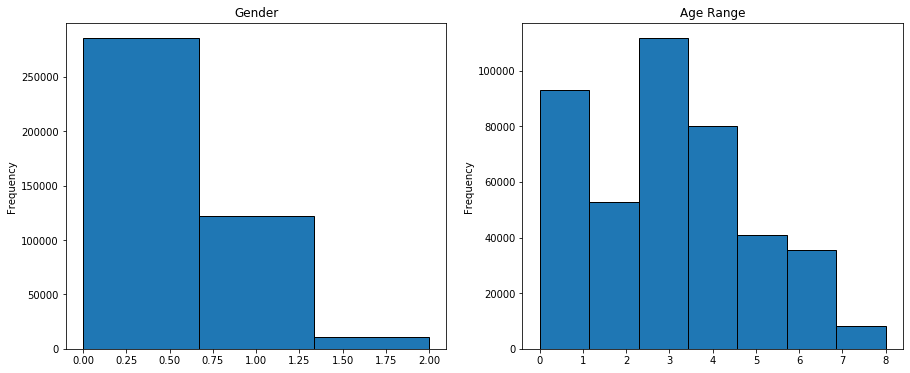

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 6), sharey=False)
user_info['gender'].plot.hist(ax=axes[0],bins=3,edgecolor='black', title="Gender")
user_info['age_range'].plot.hist(ax=axes[1],bins=7,edgecolor='black', title="Age Range")

2. Drop empty "gender" and "age_range" data

In [13]:
# fillna by by previous value
# user_info.fillna(method='ffill',inplace=True)
# dropna
user_info['age_range'] = user_info['age_range'].fillna(value=0)
user_info['gender'] = user_info['gender'].fillna(value=2)

3. Check result.  

In [14]:
print("User_info data missing: \n", user_info.apply(num_missing, axis=0),'\n')

User_info data missing: 
 user_id      0
age_range    0
gender       0
dtype: int64 



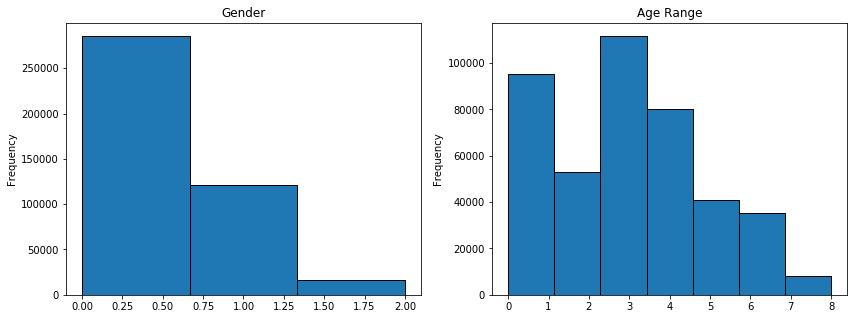

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 5), sharey=False)
user_info['gender'].plot.hist(ax=axes[0],bins=3,edgecolor='black', title="Gender")
user_info['age_range'].plot.hist(ax=axes[1],bins=7,edgecolor='black', title="Age Range")

### For User_log data
1. Principle: One brand contains multi items, but one item only belongs to one brand.

In [16]:
# Test relationship/principle
user_log[['item_id','brand_id']][user_log['item_id']==239288].head(3)

,item_id,brand_id
10,239288,4953.0
40817,239288,4953.0
55038,239288,4953.0


In [17]:
# Also have some items does not have brand_id
user_log[['item_id','brand_id']][user_log['item_id']==157368].head()

,item_id,brand_id
32109,157368,NaN


2. Fill missing value  
We can see that after fill lots of brand_id, user_log still has missing brand_id.
Some items don't have a mapped brand_id.

In [18]:
f_temp = user_log.drop_duplicates(subset=['item_id','brand_id']).set_index('item_id')['brand_id'].to_dict()
user_log[user_log['brand_id'].isna()] = user_log[user_log['brand_id'].isna()].apply(lambda x: x.fillna(f_temp[x['item_id']]), axis=1)
print("Done")

Done


4. Check the result.

In [19]:
print("In User_log, 'brand_id' still missing: \n", len(user_log[user_log['brand_id'].isna()]))

In User_log, 'brand_id' still missing: 
 86604


### Change Data Type
Save some space/memory

In [20]:
user_info[['age_range','gender']] = user_info[['age_range','gender']].astype('Int8')  # int8 : (from -128 to 127)
user_log[['user_id','item_id','cat_id']] = user_log[['user_id','item_id','cat_id']].astype('Int64')
user_log[['merchant_id','brand_id','time_stamp']] = user_log[['merchant_id','brand_id','time_stamp']].astype('Int16')
user_log[['action_type']] = user_log[['action_type']].astype('Int8')

In [21]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424170 entries, 0 to 424169
Data columns (total 3 columns):
user_id      424170 non-null int64
age_range    424170 non-null Int8
gender       424170 non-null Int8
dtypes: Int8(2), int64(1)
memory usage: 8.1 MB


In [22]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54925330 entries, 0 to 54925329
Data columns (total 9 columns):
user_id        Int64
item_id        Int64
cat_id         Int64
merchant_id    Int16
brand_id       Int16
time_stamp     Int16
action_type    Int8
time_mm        float64
time_dd        float64
dtypes: Int16(3), Int64(3), Int8(1), float64(2)
memory usage: 3.2 GB


# Feature Extraction
## A. Method

In [25]:
def feature_extract(df:pd.DataFrame, cols, grop, aggs, rname, types):
    if types == 'cnt':
        return df[cols].groupby(grop, as_index=False).count().rename(columns=rname)
    
    if types == 'sub_agg':
        return df.groupby(grop, as_index=False).agg(aggs).rename(columns=rname)

In [26]:
def max_min_normalization(df:pd.DataFrame):
    return (df-df.min())/(df.max()-df.min())

In [27]:
def time_diff(t):
    return (datetime.strptime(str(max(t)), '%m%d') - datetime.strptime(str(min(t)), '%m%d')).days

In [105]:
def auto_PCA(df:pd.DataFrame, maintain_columns=[], n=4):
    pca = PCA(n_components=n)
    pca.fit(df.drop(columns = maintain_columns))
    # the number x new feature can represent xx% infomation
    ratio = pca.explained_variance_ratio_

    def top_x():
        sum_v = 0
        for i, v in enumerate(ratio):
            sum_v += v
            # if features contains 90% info
            if sum_v > 0.9:
                return i+1
        print("Set n > ", n)
        return 0

    n = top_x()
    if n == 0: return df, n

    pca = PCA(n_components=n)
    X = pca.fit_transform(df.drop(columns = maintain_columns))
    X = pd.DataFrame(max_min_normalization(X))
    df = df[maintain_columns]
    df = pd.merge(df, X, right_index=True, left_index=True)
    return df,n

## B. Generate Feature (Dictonary)
### 1. For User
For each user_id:  
(How many kinds of xxxx that the user_id has an action)
1. Extract the count of action_types  
2. Extract the count of merchant_id  
3. Extract the count of item_id  
4. Extract the count of cat_id(categary)  
5. Extract the count of brand_id

用户每月交互、购买的次数

In [89]:
print('------Start------')
f_user = pd.DataFrame(user_info['user_id'])
f_temp = feature_extract(user_log,['user_id','action_type'],['user_id'],None,{'action_type':'f_u_action'},'cnt')
f_user = pd.merge(f_user, f_temp, on=['user_id'])

aggs = {'merchant_id':lambda x: len(set(x)), 
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'merchant_id':'f_u_merchant','item_id':'f_u_item','cat_id':'f_u_cat','brand_id':'f_u_brand'}
f_temp = feature_extract(user_log, None, ['user_id'], aggs, rnames, 'sub_agg')
f_user = pd.merge(f_user, f_temp, on=['user_id'])
print('------Done------')

------Start------
------Done------


In [93]:
cols = [n for n in f_user.columns if n != 'user_id']
f_user[cols] = max_min_normalization(f_user.drop(columns='user_id'))

In [94]:
f_user.head()

,user_id,f_u_action,f_u_merchant,f_u_item,f_u_cat,f_u_brand
0,376517,0.005323,0.011296,0.006010,0.038929,0.011816
1,234512,0.003733,0.011891,0.004428,0.041363,0.011816
2,344532,0.006152,0.011296,0.008382,0.058394,0.012438
3,186135,0.013687,0.005945,0.003163,0.024331,0.005597
4,30230,0.002074,0.007729,0.003638,0.029197,0.008085


In [106]:
f_user,_ = auto_PCA(f_user, maintain_columns=['user_id'], n=4)


In [107]:
f_user.head()

,user_id,0,1
0,376517,0.058598,0.067834
1,234512,0.059333,0.066510
2,344532,0.067432,0.062029
3,186135,0.050585,0.071046
4,30230,0.052267,0.068397


### 2. For Merchant

For each merchant:

1. Extract the count of action_types
2. Extract the count of user_id
3. Extract the count of item_id
4. Extract the count of cat_id(categary)
5. Extract the count of brand_id   

商铺每个月有多少用户交互  

In [108]:
f_merchant = pd.DataFrame(user_log['merchant_id']).drop_duplicates()
f_merchant_user = f_merchant.copy()

In [109]:
print('------Start------')

f_temp = feature_extract(user_log,['merchant_id','action_type'],['merchant_id'],None,{'action_type':'f_m_action'},'cnt')
f_merchant = pd.merge(f_merchant, f_temp, on=['merchant_id'])

aggs = {'user_id':lambda x: len(set(x)), 
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'user_id':'f_m_user','item_id':'f_m_item','cat_id':'f_m_cat','brand_id':'f_m_brand'}
f_temp = feature_extract(user_log, None, ['merchant_id'], aggs, rnames, 'sub_agg')
f_merchant = pd.merge(f_merchant, f_temp, on=['merchant_id'])

print('------Done------')

------Start------
------Done------


In [112]:
cols = [i for i in f_merchant.columns if i != 'merchant_id']
f_merchant[cols] = max_min_normalization(f_merchant.drop(columns='merchant_id'))

In [113]:
f_merchant.head()

,merchant_id,f_m_action,f_m_user,f_m_item,f_m_cat,f_m_brand
0,2882,0.012479,0.030134,0.053789,0.018797,0.002933
1,1253,0.069678,0.153207,0.114949,0.033835,0.011730
2,883,0.061223,0.063626,0.118799,0.067669,0.005865
3,420,0.287469,0.346181,0.158618,0.075188,0.017595
4,4605,0.076439,0.202515,0.024310,0.112782,0.002933


In [114]:
f_merchant,_ = auto_PCA(f_merchant, maintain_columns=['merchant_id'], n=4)

In [115]:
f_merchant.head()

,merchant_id,0,1,2
0,2882,0.372533,0.366608,0.396464
1,1253,0.437256,0.330333,0.398835
2,883,0.419042,0.365779,0.414876
3,420,0.560522,0.257749,0.372548
4,4605,0.458448,0.348996,0.342660


For each merchant:

6. Extract the count of action_types based on different gender  
7. Extract the count of action_types based on different age

In [116]:
user_log = user_log.merge(user_info,on=['user_id'])

In [117]:
for i in range(3):
    f_temp = feature_extract(user_log[user_log['gender'] == i],['merchant_id','gender'],'merchant_id',None,{'gender':'g_' + str(i)},'cnt')
    f_merchant_user = f_merchant_user.merge(f_temp, on=['merchant_id'], how='left')

In [118]:
for i in range(9):
    f_temp = feature_extract(user_log[user_log['age_range'] == i],['merchant_id','age_range'],'merchant_id',None,{'age_range':'a_' + str(i)},'cnt')
    f_merchant_user = f_merchant_user.merge(f_temp, on=['merchant_id'], how='left')

In [119]:
cols = [i for i in f_merchant_user.columns if i != 'merchant_id']
f_merchant_user[cols]= max_min_normalization(f_merchant_user.drop(columns='merchant_id'))


In [120]:
f_merchant_user.head()

,merchant_id,g_0,g_1,g_2,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8
0,420,0.286914,0.084905,0.215430,0.209402,0.083333,0.124203,0.286523,0.334569,0.251624,0.219975,0.321311,0.222441
1,4605,0.077571,0.018731,0.064635,0.060183,0.000000,0.090171,0.075860,0.059485,0.056013,0.050307,0.067633,0.070866
2,3828,0.986441,0.260324,0.947391,0.950557,0.041667,0.386078,0.785038,0.951817,1.000000,1.000000,0.928010,0.576772
3,1200,0.041729,0.050827,0.073342,0.036209,0.000000,0.042295,0.066774,0.067591,0.047568,0.039151,0.055992,0.073622
4,4043,0.086946,0.022417,0.069324,0.066105,0.000000,0.116652,0.093746,0.058086,0.051033,0.054968,0.078203,0.033465


In [121]:
# f_merchant_user,_ = auto_PCA(f_merchant_user, maintain_columns=['merchant_id'], n=4)

In [122]:
# f_merchant_user.head()

,merchant_id,0,1
0,420,0.382557,0.152495
1,4605,0.213249,0.183821
2,3828,0.926057,0.000000
3,1200,0.203615,0.180044
4,4043,0.217471,0.188986


### 3. For Category

For each category

1. Extract the count of action_types
2. Extract the count of user_id
3. Extract the count of merchant_id
4. Extract the count of item_id
5. Extract the count of brand_id

In [123]:
f_cat = pd.DataFrame(user_log['cat_id']).drop_duplicates()

In [124]:
print('------Start------')

f_temp = feature_extract(user_log,['cat_id','action_type'],['cat_id'],None,{'action_type':'f_c_action'},'cnt')
f_cat = pd.merge(f_cat, f_temp, on=['cat_id'])

aggs = {'user_id':lambda x: len(set(x)), 
        'merchant_id':lambda x: len(set(x)),
        'item_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'user_id':'f_c_user','merchant_id':'f_c_merchant','item_id':'f_c_item','brand_id':'f_c_brand'}
f_temp = feature_extract(user_log, None, ['cat_id'], aggs, rnames, 'sub_agg')
f_cat = pd.merge(f_cat, f_temp, on=['cat_id'])

print('------Done------')

------Start------
------Done------


In [125]:
cols = [i for i in f_cat.columns if i != 'cat_id']
f_cat[cols]= max_min_normalization(f_cat.drop(columns='cat_id'))

In [126]:
f_cat.head()

,cat_id,f_c_action,f_c_user,f_c_merchant,f_c_item,f_c_brand
0,833,0.023198,0.132500,0.358156,0.037017,0.336864
1,1271,0.152113,0.468678,0.431442,0.202642,0.420551
2,1467,0.183625,0.487507,0.508274,0.294936,0.516949
3,1095,0.266248,0.679624,0.821513,0.341172,0.813559
4,602,0.287638,0.478519,0.218676,0.138310,0.194915


In [127]:
f_cat,_ = auto_PCA(f_cat, maintain_columns=['cat_id'], n=4)

In [128]:
f_cat.head()

,cat_id,0
0,833,0.239082
1,1271,0.387345
2,1467,0.454549
3,1095,0.687975
4,602,0.266619


### 4. For Brand

For each Brand

1. Extract the count of action_types
2. Extract the count of user_id
3. Extract the count of merchant_id
4. Extract the count of item_id
5. Extract the count of cat_id

In [129]:
f_brand = pd.DataFrame(user_log['brand_id']).drop_duplicates().dropna()

In [130]:
print('------Start------')

f_temp = feature_extract(user_log,['brand_id','action_type'],['brand_id'],None,{'action_type':'f_b_action'},'cnt')
f_brand = pd.merge(f_brand, f_temp, on=['brand_id'])

aggs = {'user_id':lambda x: len(set(x)), 
        'merchant_id':lambda x: len(set(x)),
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x))}
rnames = {'user_id':'f_b_user','merchant_id':'f_b_merchant','item_id':'f_b_item','cat_id':'f_b_cat'}
f_temp = feature_extract(user_log, None, ['brand_id'], aggs, rnames, 'sub_agg')
f_brand = pd.merge(f_brand, f_temp, on=['brand_id'])

print('------Done------')

------Start------
------Done------


In [135]:
cols = [i for i in f_brand.columns if i != 'brand_id']
f_brand[cols]= max_min_normalization(f_brand.drop(columns='brand_id'))

In [136]:
f_brand.head()

,brand_id,f_b_action,f_b_user,f_b_merchant,f_b_item,f_b_cat
0,2661,0.012350,0.026321,0.001312,0.051379,0.010204
1,1049,0.011333,0.038287,0.000000,0.021655,0.008163
2,1647,0.059742,0.054797,0.000000,0.110317,0.036735
3,4953,0.174837,0.236520,0.000000,0.060981,0.026531
4,7622,0.074586,0.173457,0.005249,0.024923,0.044898


In [139]:
f_brand,_ = auto_PCA(f_brand, maintain_columns=['brand_id'], n=4)

In [140]:
f_brand.head()

,brand_id,0,1
0,2661,0.283892,0.279410
1,1049,0.279895,0.266240
2,1647,0.327444,0.292187
3,4953,0.416118,0.212150
4,7622,0.355782,0.240068


## C. Merge Feature Table(Dictonary)

Generated Features  
f_user  
f_merchant  
f_merchant_user  
f_item  
f_cat  
f_brand


In [141]:
train[train[label=1]]

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0
...,...,...,...
260859,359807,4325,0
260860,294527,3971,0
260861,294527,152,0
260862,294527,2537,0


In [146]:
train[train['label']==1]

,user_id,merchant_id,label
2,34176,4356,1
7,231552,3828,1
53,306816,1489,1
57,176256,3323,1
59,307584,1340,1
...,...,...,...
260747,208511,2592,1
260793,87935,1964,1
260794,87935,3734,1
260799,350591,4394,1


In [147]:
15952/260864

0.06115063788027478

In [ ]:
f_user
f_merchant
f_merchant_user
f_cat
f_brand

In [173]:
f_temp = user_log[['merchant_id','cat_id','brand_id']].drop_duplicates(subset=None, keep = 'first')

In [174]:
train_temp = pd.merge(train, f_temp, on=['merchant_id'], how='left')

In [ ]:
train_temp = pd.merge(train, user_info, on=['user_id'], how='left')

In [175]:
train_temp

,user_id,merchant_id,label,cat_id,brand_id
0,34176,3906,0,1095,6268
1,34176,3906,0,1397,6268
2,34176,3906,0,821,6268
3,34176,3906,0,154,6268
4,34176,3906,0,1577,6268
...,...,...,...,...,...
8651324,294527,2537,0,544,NaN
8651325,229247,4140,0,737,5697
8651326,229247,4140,0,1326,5697
8651327,229247,4140,0,737,NaN


In [176]:
train_temp = pd.merge(train_temp, f_user, on=['user_id'], how='left')

In [177]:
train_temp = pd.merge(train_temp, f_merchant, on=['merchant_id'], how='left')

In [178]:
# train_temp = pd.merge(train_temp, f_merchant_user, on=['merchant_id'], how='left')

In [179]:
train_temp = pd.merge(train_temp, f_cat, on=['cat_id'], how='left')

In [180]:
train_temp = pd.merge(train_temp, f_brand, on=['brand_id'], how='left')

In [ ]:
train_temp = train_temp.drop(colunms=['cat_id','brand_id'])

In [181]:
train_temp

,user_id,merchant_id,label,cat_id,brand_id,0_x,1_x,0_y,1_y,2,0_x,1_x,0_y,0,1_y
0,34176,3906,0,1095,6268,0.117340,0.081067,0.399161,0.374431,0.374951,0.17177,0.186469,0.687975,0.299165,0.272028
1,34176,3906,0,1397,6268,0.117340,0.081067,0.399161,0.374431,0.374951,0.17177,0.186469,0.617998,0.299165,0.272028
2,34176,3906,0,821,6268,0.117340,0.081067,0.399161,0.374431,0.374951,0.17177,0.186469,0.647551,0.299165,0.272028
3,34176,3906,0,154,6268,0.117340,0.081067,0.399161,0.374431,0.374951,0.17177,0.186469,0.506193,0.299165,0.272028
4,34176,3906,0,1577,6268,0.117340,0.081067,0.399161,0.374431,0.374951,0.17177,0.186469,0.790117,0.299165,0.272028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651324,294527,2537,0,544,NaN,0.068114,0.073351,0.426898,0.352208,0.356847,NaN,NaN,0.005423,NaN,NaN
8651325,229247,4140,0,737,5697,0.081227,0.070473,0.366351,0.363906,0.394474,NaN,NaN,0.542879,0.278784,0.274658
8651326,229247,4140,0,1326,5697,0.081227,0.070473,0.366351,0.363906,0.394474,NaN,NaN,0.271944,0.278784,0.274658
8651327,229247,4140,0,737,NaN,0.081227,0.070473,0.366351,0.363906,0.394474,NaN,NaN,0.542879,NaN,NaN


In [187]:
train_temp['f_age'] = train_temp.apply(lambda x: f_merchant_user[f_merchant_user['merchant_id'] == x['merchant_id']]['a_' + str(x['age'])])

,merchant_id,0,1
0,420,0.382557,0.152495
1,4605,0.213249,0.183821
2,3828,0.926057,0.000000
3,1200,0.203615,0.180044
4,4043,0.217471,0.188986
...,...,...,...
458,1842,0.156177,0.194856
459,2542,0.156905,0.186957
460,2244,0.155217,0.185678
461,3879,0.154040,0.186571


In [188]:
train_temp['f_gender'] = train_temp.apply(lambda x: f_merchant_user[f_merchant_user['merchant_id'] == x['merchant_id']]['g_' + str(x['gender'])])

,merchant_id,0,1,2
0,2882,0.372533,0.366608,0.396464
1,1253,0.437256,0.330333,0.398835
2,883,0.419042,0.365779,0.414876
3,420,0.560522,0.257749,0.372548
4,4605,0.458448,0.348996,0.342660
...,...,...,...,...
4990,2408,0.366897,0.394446,0.380059
4991,2979,0.347775,0.373684,0.379057
4992,3808,0.349199,0.374788,0.378463
4993,3532,0.354472,0.380161,0.379309
